In [70]:
import math
def kirschmer(ks, t, b, v, alpha):
    """_summary_

    Args:
        ks (_type_): _description_
        t (_type_): _description_
        b (_type_): _description_
        v (_type_): _description_
        alpha (_type_): _description_
        
        Ks = screen loss coefficient
        t = thickness of bars, m
        b = clear spacing between bars, m
        v = velocity of approach, m/sec
        a = angle of bar inclination, degree

        return hs = loss of head, m
    """
    g = 9.81 #m/s2

    hs = ks*(t/b)**(4/3)*(v**2/(2*g))*math.sin(math.radians(alpha))
    return hs

def weir(ks, t, b, h1, alpha, w):
    """calculate weir flow for screen

    Args:
        ks (_type_): _description_
        t (_type_): _description_
        b (_type_): _description_
        v (_type_): _description_
        alpha (_type_): _description_
        
        Ks = screen loss coefficient
        t = thickness of bars, m
        b = clear spacing between bars, m
        v = velocity of approach, m/sec
        a = angle of bar inclination, degree
        w = width, m
        h1 = us head, m

        return hs = loss of head, m
    """
    g = 9.81 #m/s2
    k = ks*(t/b)**(4/3)*math.sin(math.radians(alpha))
    q = 1/k**0.5*(2*g)**0.5*h1**1.5
    
    return q

def weir_drown(ks, t, b, h1, h2, h, alpha, w):
    """calculate weir flow for screen

    Args:
        Ks = screen loss coefficient
        t = thickness of bars, m
        b = clear spacing between bars, m
        v = velocity of approach, m/sec
        a = angle of bar inclination, degree, from horizontal

        w = width, m
        h1 = us depth, m
        h2 = ds depth, m
        h = screen height, m
        w = screen width, m

        return q flow
    """
    g = 9.81 #m/s2
    k = ks*(t/b)**(4/3)*math.sin(math.radians(alpha))
    q = 1/k**0.5*(2*g)**0.5*h1**1.5
    h0 = h*math.sin(math.radians(alpha)) # top of the screen
    if (h1 > h0) or (h2 > h0): #downed
        q = q*(1-(h2/h1)**1.5)**0.385
    if h2 > 0:
        q = 0 # shouldn't use weir
    
    return q

# Screen

[Reference PDF](https://web.itu.edu.tr/~bulu/hyroelectic_power_files/lecture_notes_09.pdf) pg 5

![Kirschmer Equation](./images/equation.png)



Example: Calculate the resistance of a screen with an inclination of 75 degree, where the thickness of bars s = 6.2 mm, the spacing between the bars b = 19.2 mm. The bars are of rectangular cross-section. Velocity of flow in front of the bars is V = 1.15 m/sec. 

In [25]:
hs = kirschmer(ks=2.42, t=6.2, b=19.2, v=1.15, alpha=75)
print('dh={:.2f}cm'.format(hs*100))

dh=3.49cm


## ICM Implementation

For ICM, we need to add a few more details, refer to the help document for more details.

* invert of the screen. I found it a little confusing since it is called crest. It is the elevation
* Width and height of the screen
* For the angle, it is measured from the vertical line

![Kirschmer Equation](./images/ICMmodel.png)


![Kirschmer Equation](./images/kirschmer.png)


For the engine to apply the formula, velocity was calculated from 

```Q=v*width*height```

However, there seems to be an error in the formula. For width, it should be the channel width instead of the screen opening.

![Kirschmer Equation](./images/engine_equation.png)

When the screen is drowned, the Villemonthe equation is used.

![Kirschmer Equation](./images/drowned.png)






## ICM simulated headloss vs headloss calculated from Velocity

The simulation results shows the following,
* US depth/DS depth: h1, h2 above the invert(crest) of the screen. The screen link is a flat channel. Headloss = h1 - h2
* US velocity: the approaching velocity using the full width of the channel

dh = h1 -h2

dh_eq = KirschmerFn(velocity)

As shown in the results, below they match very well with a R square of 0.99.

<AxesSubplot:xlabel='time_min'>

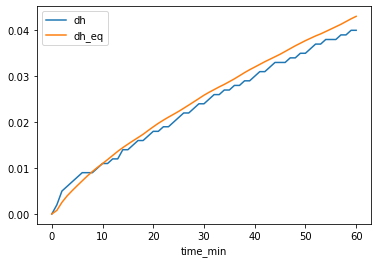

In [38]:
import pandas as pd
f = r"C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\screen\screen.xlsx"
df = pd.read_excel(f, 'icm')
# headloss from ICM results
df['dh'] = df['US depth (m)'] - df['DS depth (m)']
# headloss using approaching velocity with k-equation
df['dh_eq'] = df.apply(lambda x: kirschmer(ks=2.42, t=6.2, b=19.2, v=x['US velocity (m/s)'], alpha=75), axis=1)
df.index = df['time_min']
df.loc[:, ['dh', 'dh_eq']].plot()


<AxesSubplot:xlabel='dh', ylabel='dh_eq'>

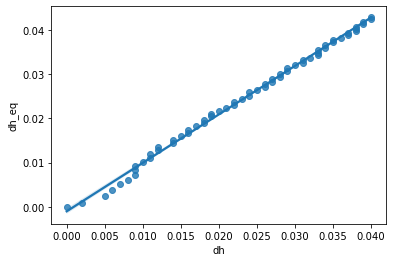

In [37]:
import seaborn as sns

sns.regplot(data=df, x='dh', y='dh_eq')

In [36]:
import statsmodels.api as sm

sm.OLS(df['dh'], df['dh_eq']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     dh   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.478e+04
Date:                Tue, 04 Oct 2022   Prob (F-statistic):                    9.99e-93
Time:                        11:04:44   Log-Likelihood:                          349.68
No. Observations:                  61   AIC:                                     -697.4
Df Residuals:                      60   BIC:                                     -695.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dh_eq          0.9418      0.004    254.528      0.000       0.934       0.949
==============================================================================
Omnibus:                       27.416   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.880
Skew:                           1.657   Prob(JB):                     2.96e-10
Kurtosis:                       5.507   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Velocity through the screen

To calculate the velocity through the screen, you need to calculate the openning of the screen. As shown in the comparison, the reported US velocity is the approaching velocity.

In [57]:
#effective width
import math

w = 1 #m
s = 6.2 #mm
b = 19.2 #mm

#no of openings
n = math.ceil(w*1000/(s + b))
wb = n*b/1000
print('Effective width (opening only) is {:.2f}m'.format(wb))

Effective width (opening only) is 0.77m


In [53]:
df['v_eff'] = df['US flow (m3/s)']/df['US depth (m)']/wb
df['v_approach'] = df['US flow (m3/s)']/df['US depth (m)']/1

<AxesSubplot:xlabel='time_min'>

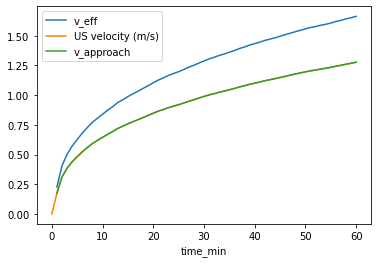

In [54]:
df.loc[:, ['v_eff', 'US velocity (m/s)', 'v_approach']].plot()

## Weir Conditions

The results confirmed that the channel width is used instead.

<AxesSubplot:xlabel='time_min'>

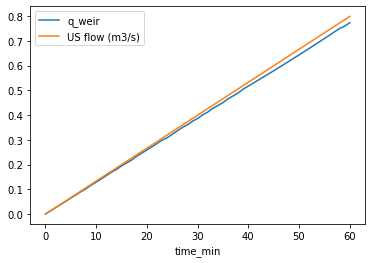

In [59]:
import pandas as pd
f = r"C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\screen\screen.xlsx"
df = pd.read_excel(f, 'weir')
# headloss from ICM results
df['dh'] = df['US depth (m)'] - df['DS depth (m)']
# headloss using approaching velocity with k-equation
df['q_weir'] = df.apply(lambda x: weir(h1=x['US depth (m)'], w=1, ks=2.42, t=6.2, b=19.2, alpha=75), axis=1)
df.index = df['time_min']
df.loc[:, ['q_weir', 'US flow (m3/s)']].plot()

<AxesSubplot:xlabel='q_weir', ylabel='US flow (m3/s)'>

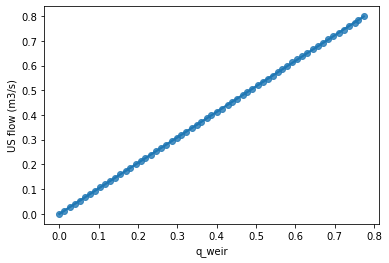

In [60]:
sns.regplot(data=df, x='q_weir', y='US flow (m3/s)')

In [62]:
sm.OLS(df['q_weir'], df['US flow (m3/s)']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 q_weir   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.026e+07
Date:                Tue, 04 Oct 2022   Prob (F-statistic):                   1.06e-158
Time:                        12:22:07   Log-Likelihood:                          329.79
No. Observations:                  61   AIC:                                     -657.6
Df Residuals:                      60   BIC:                                     -655.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
US flow (m3/s)     0.9683      0.000   3202.461      0.000       0.968       0.969
==============================================================================
Omnibus:                        4.720   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                2.133
Skew:                           0.087   Prob(JB):                        0.344
Kurtosis:                       2.100   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Drowned

It is not turned on in my model, so the kirschmer is used instead for the calculation.

<AxesSubplot:xlabel='time_min'>

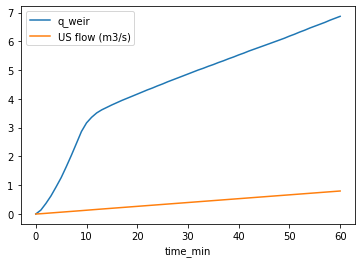

In [63]:
import pandas as pd
f = r"C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\screen\screen.xlsx"
df = pd.read_excel(f, 'drowned')
# headloss from ICM results
df['dh'] = df['US depth (m)'] - df['DS depth (m)']
# headloss using approaching velocity with k-equation
df['q_weir'] = df.apply(lambda x: weir(h1=x['US depth (m)'], w=1, ks=2.42, t=6.2, b=19.2, alpha=75), axis=1)
df.index = df['time_min']
df.loc[:, ['q_weir', 'US flow (m3/s)']].plot()

<AxesSubplot:xlabel='time_min'>

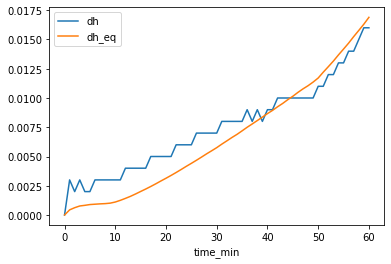

In [64]:
import pandas as pd
f = r"C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\screen\screen.xlsx"
df = pd.read_excel(f, 'drowned')
# headloss from ICM results
df['dh'] = df['US depth (m)'] - df['DS depth (m)']
# headloss using approaching velocity with k-equation
df['dh_eq'] = df.apply(lambda x: kirschmer(ks=2.42, t=6.2, b=19.2, v=x['US velocity (m/s)'], alpha=75), axis=1)
df.index = df['time_min']
df.loc[:, ['dh', 'dh_eq']].plot()

In [65]:

sm.OLS(df['dh'], df['dh_eq']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     dh   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              1692.
Date:                Tue, 04 Oct 2022   Prob (F-statistic):                    1.14e-45
Time:                        12:28:46   Log-Likelihood:                          308.32
No. Observations:                  61   AIC:                                     -614.6
Df Residuals:                      60   BIC:                                     -612.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dh_eq          1.0116      0.025     41.134      0.000       0.962       1.061
==============================================================================
Omnibus:                       24.445   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.163
Skew:                          -0.444   Prob(JB):                       0.0459
Kurtosis:                       1.721   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='dh', ylabel='dh_eq'>

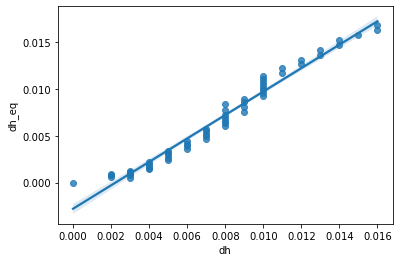

In [66]:
sns.regplot(data=df, x='dh', y='dh_eq')

## Drowned V equation

<AxesSubplot:xlabel='time_min'>

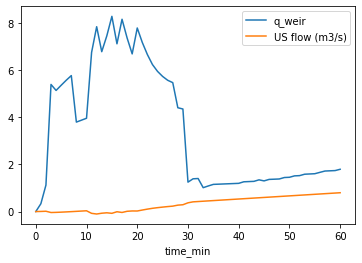

In [74]:
import pandas as pd
f = r"C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\screen\screen.xlsx"
df = pd.read_excel(f, 'drowned-v')
# headloss from ICM results
df['dh'] = df['US depth (m)'] - df['DS depth (m)']
# headloss using approaching velocity with k-equation
df['q_weir'] = df.apply(lambda x: weir_drown(h1=x['US depth (m)'],h2=x['DS depth (m)'], h=1,  w=1, ks=2.42, t=6.2, b=19.2, alpha=75), axis=1)
df.index = df['time_min']
df.loc[:, ['q_weir', 'US flow (m3/s)']].plot()

<AxesSubplot:xlabel='time_min'>

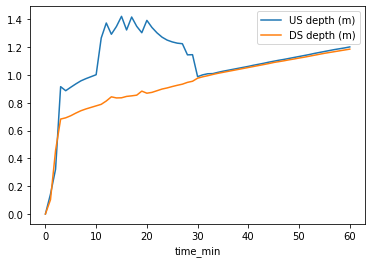

In [75]:
df.loc[:, ['US depth (m)', 'DS depth (m)']].plot()

<AxesSubplot:xlabel='time_min'>

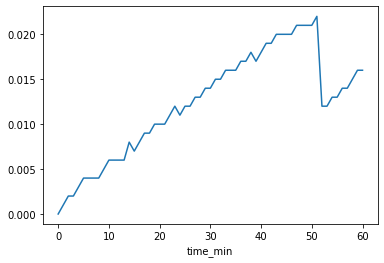

In [73]:
df['dh'].plot()